In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
import matplotlib.tri as tri
from mpl_toolkits.axes_grid1 import make_axes_locatable

# a class for fancy 3d arrow plotting
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs
    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

As a prime basis, we use the basis from (Chen & Douglas, 1989) which has a dimension of 15.

In [2]:
def ChenDouglas(x,y,z):
    V = np.zeros((3,x.size,15))
    O = np.zeros(x.size)
    for d in range(3):
        V[d,:,4*d+0] = np.ones(x.size)
        V[d,:,4*d+1] = x
        V[d,:,4*d+2] = y
        V[d,:,4*d+3] = z
    V[...,12] = [    O, y**2, -2*y*z] # curl(y**2 z,       0, 0)
    V[...,13] = [2*x*y,2*y*z,-2*z**2] # curl(y z**2, -x z**2, 0)
    V[...,14] = [-x**2,    O,  2*x*z] # curl(     0,  x**2 z, 0)
    return V

These routines will give us an even sampling of points on the triangle/prism.

In [3]:
def CreateTriangleLocations(n):
    u = np.linspace(-1,1,n)
    x,y = np.meshgrid(u,u)
    x = x.flatten(); y = y.flatten()
    ind = np.where(x<(-y)+2/n/10)
    return x[ind],y[ind]

def CreatePrismLocations(n):
    zp = np.linspace(-1,1,n)
    xp,yp = CreateTriangleLocations(n)
    x = xp[:,np.newaxis] * np.ones(zp.size)
    y = yp[:,np.newaxis] * np.ones(zp.size)
    z = np.ones(xp.shape)[:,np.newaxis] * zp
    return x.flatten(order='f'),y.flatten(order='f'),z.flatten(order='f')

The primastic basis of (Chen & Douglas, 1989) is of dimension 15 which falls 3 basis functions short of being able to setup a nodal basis which coincides with vertices. The basis leads to linear traces on faces, but not bilinear on the quadrilateral faces.

So to get a nodal basis, we need to pick 3 conditions per each of 5 faces. For the triangular faces, we choose the normal component at each vertex. For the quadrilateral faces, we choose the normal component at each of the bottom vertices as well as the normal component at the top edge midpoint. Although not a traditional choice of nodal unknowns, these lead to local element spaces that can be assembled into a global space provided that prisms are meshed in a uniformly bottom-up fashion.

In [4]:
xn = np.zeros(15); yn = np.zeros(15); zn = np.zeros(15); n = np.zeros((15,3)); s = 1/np.sqrt(2)

# face x = -1
xn[0],yn[0],zn[0] = -1,-1,-1
xn[1],yn[1],zn[1] = -1,+1,-1
xn[2],yn[2],zn[2] = -1, 0,+1
n[:3,0] = -1

# face y = -1
xn[3],yn[3],zn[3] = -1,-1,-1
xn[4],yn[4],zn[4] = +1,-1,-1
xn[5],yn[5],zn[5] =  0,-1,+1
n[3:6,1] = -1

# face z = -1
xn[6],yn[6],zn[6] = -1,-1,-1
xn[7],yn[7],zn[7] = +1,-1,-1
xn[8],yn[8],zn[8] = -1,+1,-1
n[6:9,2] = -1

# face y = -x
xn[ 9],yn[ 9],zn[ 9] = +1,-1,-1
xn[10],yn[10],zn[10] = -1,+1,-1
xn[11],yn[11],zn[11] =  0, 0,+1
n[9:12,:2] = s

# face z = +1
xn[12],yn[12],zn[12] = -1,-1,+1
xn[13],yn[13],zn[13] = +1,-1,+1
xn[14],yn[14],zn[14] = -1,+1,+1
n[12:15,2] = 1 

Now we can plot the reference prism along with the nodal unknowns shown as vectors. Each color corresponds to a different face to highlight that there are 3 unknowns per face. 

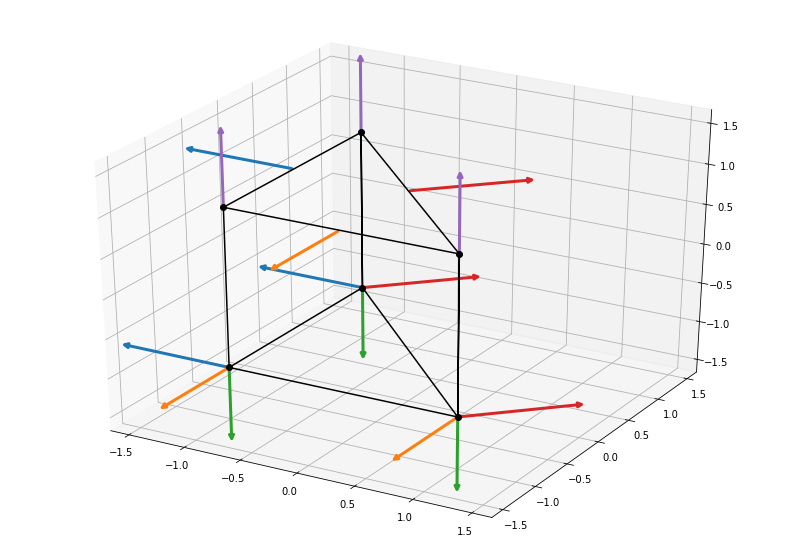

In [5]:
xv,yv,zv = CreatePrismLocations(2)
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111,projection='3d')
cell = [0,1,2,0,3,4,1,4,5,2,5,3]
plt.plot(xv[cell],yv[cell],zv[cell],'-k')
plt.plot(xv,yv,zv,'ok')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i in range(5):
    clr = colors[i]
    for j in range(3):
        k = i*3+j
        ax.add_artist(Arrow3D([xn[k],xn[k]+n[k,0]],
                              [yn[k],yn[k]+n[k,1]],
                              [zn[k],zn[k]+n[k,2]], 
                              mutation_scale=10,lw=3,arrowstyle="-|>",color=clr))
L,R = -1.6,1.6; ax.set_xlim(L,R); ax.set_ylim(L,R); ax.set_zlim(L,R)
plt.show()

Now we can solve for the nodal basis by computing the generalized Vandermonde matrix and using its inverse to transform a fine set of points. The 3D vector basis functions are hard to visualize, so here we will plot the normal component on each face as a color contour. This also confirms that we are capturing our conditions correctly and gives some intuition as to what the space spans.

In particular, I wonder about the bases on the diagonal face. While they appear to exhibit the correct nodal behavior, it seems this face spans more than the other faces. It strikes me that this will mean that results will depend on the orientation of the prism, which for me is undesirable. I think that it would also present a meshing challenge as the diagonal faces would need to match? This isn't such a big deal in practice as we could split the quadrilateral, but it still is not a great feature.

In [6]:
xp,yp,zp = CreatePrismLocations(31)
P = ChenDouglas(xp,yp,zp)
V = np.einsum('dij,id->ij',ChenDouglas(xn,yn,zn),n)
N = np.linalg.inv(V).T @ np.swapaxes(P,2,1)

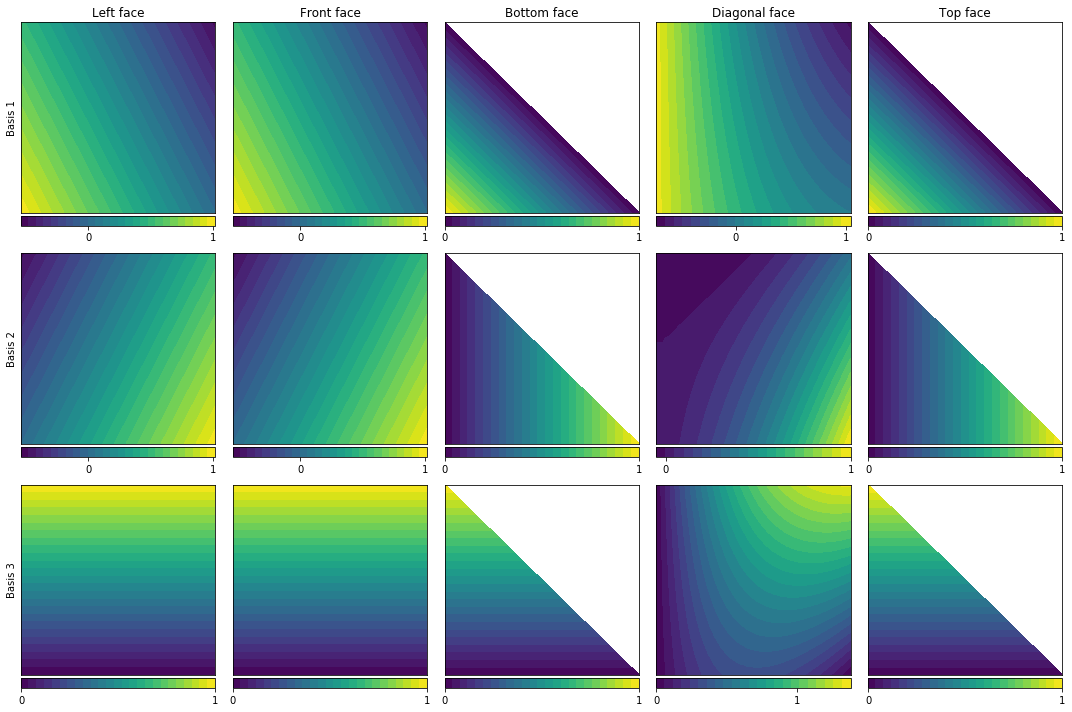

In [7]:
def PlotBasisPlane(condition,x,y,normal,basis,ax):
    ind = np.where(condition)[0]
    T = tri.Triangulation(x[ind],y[ind])
    data = normal @ basis[:,ind]
    p = ax.tricontourf(T,data,25)
    ax.set_xticks([]); ax.set_yticks([])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('bottom',size='5%',pad=0.05)
    plt.colorbar(p,cax=cax,ticks=[0,1],orientation='horizontal')

    
fig,ax = plt.subplots(nrows=3,ncols=5,tight_layout=True,figsize=(15,10))
PlotBasisPlane(np.abs(xp-(-1))<1e-3,yp,zp,n[0],N[:,0,:],ax[0,0])
PlotBasisPlane(np.abs(xp-(-1))<1e-3,yp,zp,n[1],N[:,1,:],ax[1,0])
PlotBasisPlane(np.abs(xp-(-1))<1e-3,yp,zp,n[2],N[:,2,:],ax[2,0])

PlotBasisPlane(np.abs(yp-(-1))<1e-3,xp,zp,n[3],N[:,3,:],ax[0,1])
PlotBasisPlane(np.abs(yp-(-1))<1e-3,xp,zp,n[4],N[:,4,:],ax[1,1])
PlotBasisPlane(np.abs(yp-(-1))<1e-3,xp,zp,n[5],N[:,5,:],ax[2,1])

PlotBasisPlane(np.abs(zp-(-1))<1e-3,xp,yp,n[6],N[:,6,:],ax[0,2])
PlotBasisPlane(np.abs(zp-(-1))<1e-3,xp,yp,n[7],N[:,7,:],ax[1,2])
PlotBasisPlane(np.abs(zp-(-1))<1e-3,xp,yp,n[8],N[:,8,:],ax[2,2])

PlotBasisPlane(np.abs(xp+yp)<1e-3,yp,zp,n[ 9],N[:, 9,:],ax[0,3])
PlotBasisPlane(np.abs(xp+yp)<1e-3,yp,zp,n[10],N[:,10,:],ax[1,3])
PlotBasisPlane(np.abs(xp+yp)<1e-3,yp,zp,n[11],N[:,11,:],ax[2,3])

PlotBasisPlane(np.abs(zp-(+1))<1e-3,xp,yp,n[12],N[:,12,:],ax[0,4])
PlotBasisPlane(np.abs(zp-(+1))<1e-3,xp,yp,n[13],N[:,13,:],ax[1,4])
PlotBasisPlane(np.abs(zp-(+1))<1e-3,xp,yp,n[14],N[:,14,:],ax[2,4])

ax[0,0].set_title("Left face")
ax[0,1].set_title("Front face")
ax[0,2].set_title("Bottom face")
ax[0,3].set_title("Diagonal face")
ax[0,4].set_title("Top face")
ax[0,0].set_ylabel("Basis 1")
ax[1,0].set_ylabel("Basis 2")
ax[2,0].set_ylabel("Basis 3")
plt.show()